<a href="https://colab.research.google.com/github/jejjohnson/gp_model_zoo/blob/master/code/numpyro/numpyro_sparsegp_uncertain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse Gaussian Process w/ Numpyro

My starting notebook where I install all of the necessary libraries and load some easy 1D/2D Regression data to play around with.

In [ ]:
#@title Install Packages
%%capture
!pip install jax jaxlib chex optax loguru
!pip install "git+https://github.com/pyro-ppl/numpyro.git#egg=numpyro"
!pip uninstall tensorflow -y -q
!pip install -Uq tfp-nightly[jax] > /dev/null

In [ ]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as jnp
import jax.random as random


# JAX UTILITY LIBRARIES
import chex

# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import loguru

%load_ext autoreload
%autoreload 2

## Gaussian Process Model

In [ ]:





def GP(X, y):
    # Set informative log-normal priors on kernel hyperparameters.
    # η = pm.HalfCauchy("η", beta=5)
    # η = numpyro.sample("variance", dist.HalfCauchy(scale=5.))
    # ℓ = numpyro.sample("length_scale", dist.Gamma(2., 1.))
    # σ = numpyro.sample("noise", dist.HalfCauchy(scale=5.))

    η = numpyro.param("kernel_var", init_value=1.0, constraints=dist.constraints.positive)
    ℓ = numpyro.param("kernel_length", init_value=0.1,  constraints=dist.constraints.positive)
    σ = numpyro.param("sigma", init_value=0.01, onstraints=dist.constraints.positive)

    # Compute kernel
    K = rbf_kernel(X, X, η, ℓ)
    K += jnp.eye(X.shape[0]) * jnp.power(σ, 2)

    Lff = jnp.linalg.cholesky(K)

    # Sample y according to the standard gaussian process formula
    return numpyro.sample("y", dist.MultivariateNormal(
        loc=jnp.zeros(X.shape[0]),
        scale_tril=Lff
        )
        .expand_by(y.shape[:-1]).to_event(y.ndim - 1)
        , 
        obs=y
    )


def empty_guide(X, y):
    pass

In [ ]:
K = rbf_kernel(x, x, 1.0, 1.0)

# check shape
chex.assert_shape(K, (x.shape[0], x.shape[0]))

## Exact GP - Maximum Marginal Likelihood

In [ ]:
from numpyro.infer.autoguide import AutoDelta#AutoDiagonalNormal, AutoIAFNormal, AutoLaplaceApproximation, AutoMultivariateNormal

In [ ]:
type(x), type(y), y.shape

(jax.interpreters.xla._DeviceArray, jax.interpreters.xla._DeviceArray, (50, 1))

In [ ]:
with numpyro.handlers.seed(rng_seed=123):
    t = GP(x, y)


In [ ]:
print(t.shape)

(50, 1)


In [ ]:
# reproducibility
rng_key = random.PRNGKey(0)

gp_model = GP

# Setup
# guide = numpyro.infer.autoguide.AutoDelta(GP)
optimizer = numpyro.optim.Adam(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(gp_model, empty_guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(random.PRNGKey(1), 1_000, x, y.T)

100%|██████████| 1000/1000 [00:02<00:00, 412.30it/s, init loss: 822.0859, avg. loss [951-1000]: 18.4708]


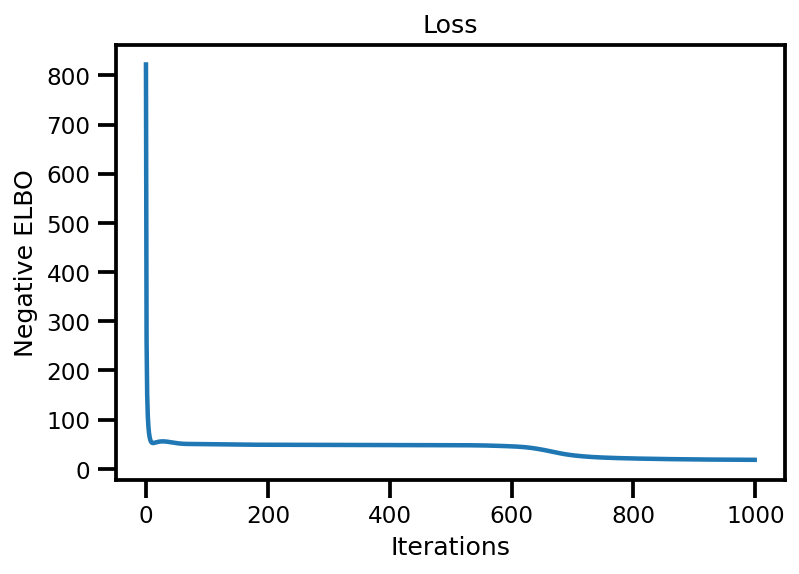

In [ ]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative ELBO"
    );
plt.show()

### Extracting the Params

In [ ]:
from pprint import pprint
# Take them directly
learned_params = svi_results.params
pprint(learned_params)

{'kernel_length': DeviceArray(0.39, dtype=float32),
 'kernel_var': DeviceArray(0.842, dtype=float32),
 'sigma': DeviceArray(0.19, dtype=float32)}


### Predictions

In [ ]:
def cholesky_factorization(K: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, bool]:
    """Cholesky Factorization"""
    # cho factor the cholesky
    L = jax.scipy.linalg.cho_factor(K, lower=True)

    # weights
    weights = jax.scipy.linalg.cho_solve(L, Y)

    return L, weights

# Predictive Mean and Variance
def predict(X, Y, X_test, variance, length_scale, noise):

    K = rbf_kernel(X, X, variance, length_scale)
    L, alpha = cholesky_factorization(K + noise * np.eye(K.shape[0]), Y)

    # Calculate the Mean
    K_x = rbf_kernel(X_test, X, variance, length_scale)
    mu_y = np.dot(K_x, alpha)

    # Calculate the variance
    v = jax.scipy.linalg.cho_solve(L, K_x.T)

    # Calculate kernel matrix for inputs
    K_xx = rbf_kernel(X_test, X_test, variance, length_scale)

    cov_y = K_xx - jnp.dot(K_x, v)
    return mu_y, cov_y


# Summarize function posterior.
def posterior(rng_key, X, Y, X_test, variance, length_scale, noise):
    m, cov = predict(X, Y, X_test, variance, length_scale, noise)

    return random.multivariate_normal(rng_key, mean=m, cov=cov)

def summarize_posterior(preds, ci=96):
    ci_lower = (100 - ci) / 2
    ci_upper = (100 + ci) / 2
    preds_mean = preds.mean(0)
    preds_lower = jnp.percentile(preds, ci_lower, axis=0)
    preds_upper = jnp.percentile(preds, ci_upper, axis=0)
    return preds_mean, preds_lower, preds_upper

In [ ]:
y_pred, y_cov = predict(
    x, y.squeeze(), xtest, 
    variance=learned_params['kernel_var'], 
    length_scale=learned_params['kernel_length'], 
    noise=learned_params['sigma']
)

y_var = jnp.diagonal(y_cov)
y_std = jnp.sqrt(y_var)

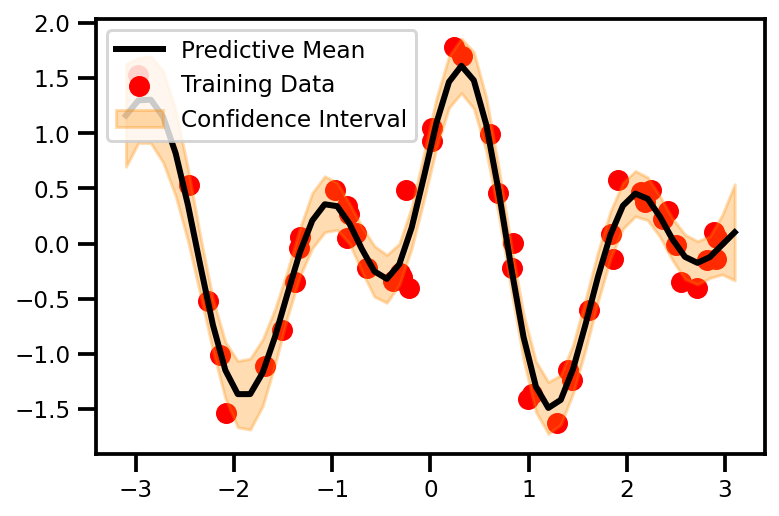

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(x, y, label='Training Data', color='red')
ax.plot(xtest, y_pred, label='Predictive Mean', color='black', linewidth=3)
ax.fill_between(
    xtest.squeeze(),
    y_pred - y_std,
    y_pred + y_std,
    label='Confidence Interval',
    alpha=0.3,
    color='darkorange'
    )
ax.legend()

## Sparse GP

In [ ]:
seed = 123
key = jax.random.PRNGKey(seed=seed)

N = 1_000
Ninducing = 50
Nfeatures = 1
Ntest = 1_000
noise = 0.2


# x = jax.random.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
# f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
# signal = f(x)
# y = signal + jax.random.normal(key, shape=signal.shape) * noise

# xtest = jnp.linspace(-3.5, 3.5, Ntest).reshape(-1, 1)
# ytest = f(xtest)


# x = jax.random.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
# f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
# signal = f(x)
# y = signal + jax.random.normal(key, shape=signal.shape) * noise

# x = jax.random.uniform(key=key, minval=0.0, maxval=5.0, shape=(N,)).sort().reshape(-1, 1)
# f = lambda x: 0.5 * jnp.sin(3.0 * x)
# signal = f(x)
# y = signal + noise * jax.random.normal(key, shape=signal.shape)

# rng.rand(N, 1) * 2 - 1 
x = jnp.linspace(-1.0, 1., 1_000).reshape(-1, 1) #* 2.0 - 1.0
f = lambda x: jnp.sin(x * 3 * 3.14) + 0.3 * jnp.cos(x * 9 * 3.14) + 0.5 * jnp.sin(x * 7 * 3.14)

signal = f(x)
y = signal + noise * jax.random.normal(key, shape=signal.shape)


xtest = jnp.linspace(-1.1, 1.1, 1_000).reshape(-1, 1)
ytest = f(xtest)

In [ ]:
x.min(), x.max()

(DeviceArray(-1., dtype=float32), DeviceArray(1., dtype=float32))

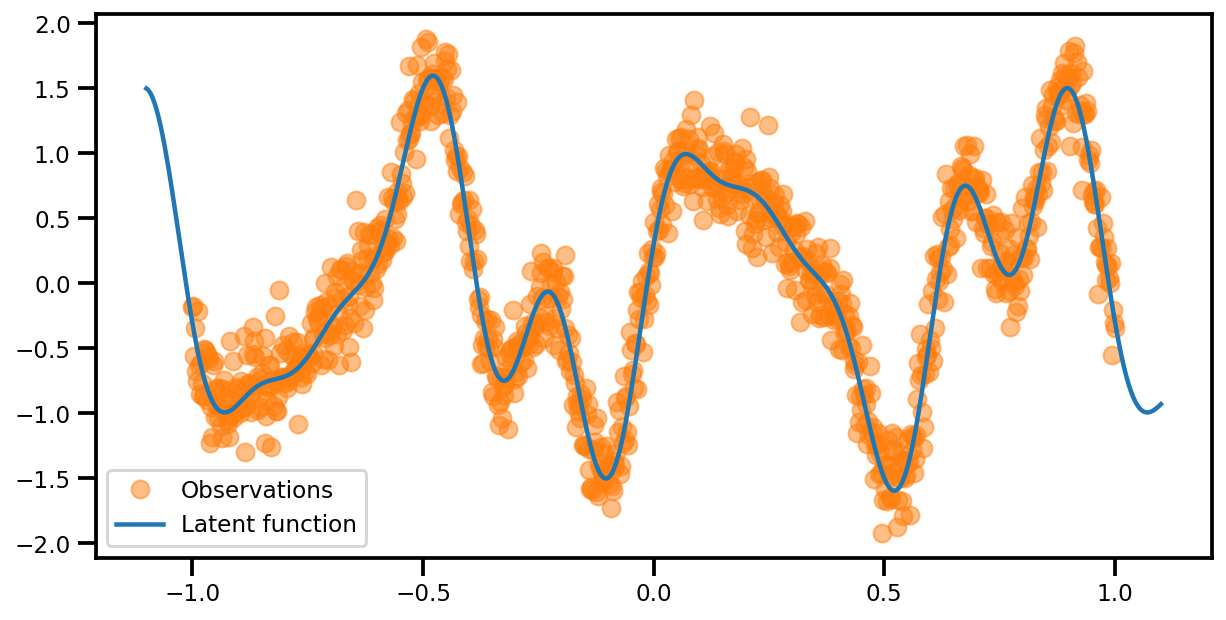

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, "o", label="Observations", color="tab:orange", alpha=0.5)
ax.plot(xtest, ytest, label="Latent function", color="tab:blue")
ax.legend(loc="best")
plt.show()

### Model

#### Inducing Points

In [ ]:
from scipy.cluster.vq import kmeans2

def init_inducing_kmeans(x: chex.Array, n_inducing: int)-> chex.Array:
    # conver to numpy array
    x = np.array(x)

    # calculate k-means
    x_u_init = kmeans2(x, n_inducing, minit="points")[0]

    # convert to jax array
    x_u_init = jnp.array(x_u_init)

    return x_u_init

def init_inducing_subsample(key, x: chex.Array, n_inducing: int) -> chex.Array:

    # random permutation and subsample
    x_u_init = jax.random.permutation(key, x)[:n_inducing]

    return x_u_init

In [ ]:
Ninducing = 20


x_u_init = init_inducing_kmeans(x, Ninducing)
print(x_u_init.shape)

(20, 1)


In [ ]:
# squared euclidean distance
def sqeuclidean_distance(x: np.array, y: np.array) -> float:
    return jnp.sum((x - y) ** 2)

# distance matrix
def cross_covariance(func: Callable, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """distance matrix"""
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)

# kernel function
def rbf_kernel(X, Y, variance, length_scale):
    # distance formula
    deltaXsq = cross_covariance(
        sqeuclidean_distance, 
        X / length_scale, 
        Y / length_scale
    )

    # rbf function
    K = variance * jnp.exp(-0.5 * deltaXsq)
    return K

In [ ]:




def SparseGP(X, y):

    n_samples = X.shape[0]
    # Set informative log-normal priors on kernel hyperparameters.
    # η = pm.HalfCauchy("η", beta=5)
    η = numpyro.sample("kernel_var", dist.HalfCauchy(scale=5.))
    ℓ = numpyro.sample("kernel_length", dist.Gamma(2., 1.))
    σ = numpyro.sample("sigma", dist.HalfCauchy(scale=5.))

    x_u = numpyro.param("x_u", init_value=x_u_init)

    # η = numpyro.param("kernel_var", init_value=1.0, constraints=dist.constraints.positive)
    # ℓ = numpyro.param("kernel_length", init_value=1.0,  constraints=dist.constraints.positive)
    # σ = numpyro.param("sigma", init_value=1.0, onstraints=dist.constraints.positive)

    

    # ================================
    # Qff Term
    # ================================
    # W   = (inv(Luu) @ Kuf).T
    # Qff = Kfu @ inv(Kuu) @ Kuf
    # Qff = W @ W.T
    # ================================
    Kuu = rbf_kernel(x_u, x_u, η, ℓ)
    Kuf = rbf_kernel(x_u, X, η, ℓ)
    Kuu += jnp.eye(Ninducing) * 1e-5#jax.ops.index_add(Kuu, Ninducing, 1e-5)
    # print(Kuu.min(), Kuu.max())
    Luu = jnp.linalg.cholesky(Kuu)
    # print(Luu.min(), Luu.max())
    # print(Luu.shape)
    W = jax.scipy.linalg.solve_triangular(Luu, Kuf, lower=True).T

    # print(W.shape)

    # Luu = jax.scipy.linalg.cho_factor(Kuu, lower=True)
    # W = jax.scipy.linalg.cho_solve(Luu, Kuf).T

    # ================================
    # Likelihood Noise Term
    # ================================
    # D = noise
    # ================================
    D = jnp.ones(n_samples) * σ
    
    # ================================
    # trace term
    # ================================
    # t = tr(Kff - Qff) / noise
    # t = - t / 2.0
    # ================================
    Kffdiag = jnp.diag(rbf_kernel(X, X, η, ℓ))
    # print(Kffdiag.min(), Kffdiag.max())
    Qffdiag = jnp.power(W, 2).sum(axis=1)
    # print(Qffdiag.min(), Qffdiag.max())
    trace_term = (Kffdiag - Qffdiag).sum() / σ
    trace_term = jnp.clip(trace_term, a_min=0.0)  # numerical errors
    # print(trace_term)
    numpyro.factor("trace_term", - trace_term/2.0)

    # ================================
    # Mean Function
    # ================================
    f_loc = np.zeros(n_samples)



    # Sample y according SGP
    return numpyro.sample("y", dist.LowRankMultivariateNormal(
        loc=f_loc, cov_factor=W, cov_diag=D)
        .expand_by(y.shape[:-1]).to_event(y.ndim - 1), 
        obs=y
    )


def empty_guide(X, y):
    pass

In [ ]:
with numpyro.handlers.seed(rng_seed=123):
    t = SparseGP(x, y.T)

print(t.shape)

(1, 1000)


In [ ]:
from numpyro.infer.autoguide import AutoDelta

sgp_model = SparseGP
guide = AutoDelta(sgp_model)

In [ ]:
y.shape, x.shape

((1000, 1), (1000, 1))

In [ ]:


# reproducibility
rng_key = random.PRNGKey(0)


n_epochs = 2_500

# Setup
optimizer = numpyro.optim.Adam(step_size=0.005)
# optimizer = numpyro.optim.Minimize()

svi = SVI(sgp_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(random.PRNGKey(1), n_epochs, x, y.T)

100%|██████████| 2500/2500 [00:27<00:00, 89.43it/s, init loss: 2013.5096, avg. loss [2376-2500]: -53.4051]


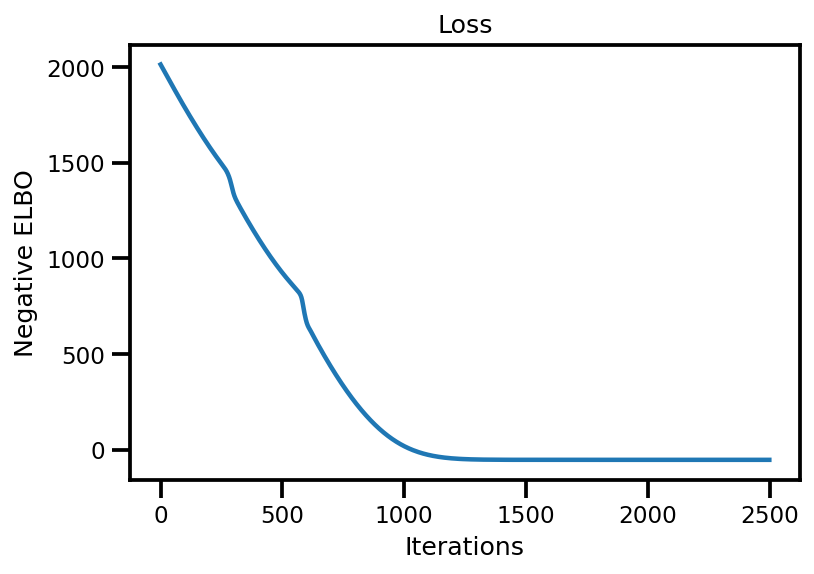

In [ ]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative ELBO"
    );
plt.show()

In [ ]:
def concat_dictionaries(a: dict, b: dict) -> dict:
    """
    Append one dictionary below another. If duplicate keys exist, then the key-value pair of the second supplied
    dictionary will be used.
    """
    return {**a, **b}

In [ ]:
from pprint import pprint
# Take them directly
learned_params = svi_results.params
pprint(learned_params)

# Take them directly
median_params = guide.median(learned_params)
learned_params = concat_dictionaries(learned_params, median_params)
pprint(learned_params)

{'kernel_length_auto_loc': DeviceArray(0.108, dtype=float32),
 'kernel_var_auto_loc': DeviceArray(0.877, dtype=float32),
 'sigma_auto_loc': DeviceArray(0.044, dtype=float32),
 'x_u': DeviceArray([[ 0.462],
             [ 0.17 ],
             [ 0.266],
             [ 0.667],
             [-0.537],
             [ 0.562],
             [ 0.878],
             [-0.755],
             [-0.868],
             [-0.328],
             [-0.963],
             [-0.645],
             [-0.124],
             [ 0.969],
             [ 0.073],
             [ 0.774],
             [-0.226],
             [-0.025],
             [-0.43 ],
             [ 0.364]], dtype=float32)}
{'kernel_length': DeviceArray(0.108, dtype=float32),
 'kernel_length_auto_loc': DeviceArray(0.108, dtype=float32),
 'kernel_var': DeviceArray(0.877, dtype=float32),
 'kernel_var_auto_loc': DeviceArray(0.877, dtype=float32),
 'sigma': DeviceArray(0.044, dtype=float32),
 'sigma_auto_loc': DeviceArray(0.044, dtype=float32),
 'x_u': DeviceArr

#### Predictions

In [ ]:
from chex import Array
from copy import deepcopy

def sparse_cholesky_factorization(
    learned_params: dict,
    x: Array, y: Array, 
    jitter: 1e-5
    ) -> dict:

    params = deepcopy(learned_params)
    n_samples = x.shape[0]
    m_samples = learned_params["x_u"].shape[0]
    jitter = 1e-5

    # calculate the cholesky factorization
    Kuu = rbf_kernel(
        params["x_u"], 
        params["x_u"], 
        params["kernel_var"], 
        params["kernel_length"]
        )
    Kuu += np.eye(m_samples) * jitter
    Luu = jnp.linalg.cholesky(Kuu)

    Kuf = rbf_kernel(
        params["x_u"], x,
        params["kernel_var"], 
        params["kernel_length"]
        )

    W = jax.scipy.linalg.solve_triangular(Luu, Kuf, lower=True)
    D = np.ones(n_samples) * params["sigma"]

    W_Dinv = W / D
    K = W_Dinv @ W.T
    K = jax.ops.index_add(K, Ninducing, 1.0)

    L = jnp.linalg.cholesky(K)

    # mean function
    y_residual = y # mean function
    y_2D = y_residual.reshape(-1, n_samples).T
    W_Dinv_y = W_Dinv @ y_2D

    params["Luu"] = Luu
    params["W_Dinv_y"] = W_Dinv_y
    params["L"] = L
    params["y_shape"] = y.shape[:-1]

    return params



In [ ]:
params = sparse_cholesky_factorization(learned_params, x, y.T, jitter=1e-5)

In [ ]:
def _pred_factorize(params, xtest):

    Kux = rbf_kernel(
        params["x_u"],
        xtest,
        params["kernel_var"],
        params["kernel_length"]
    )
    Ws = jax.scipy.linalg.solve_triangular(
        params["Luu"], Kux, lower=True
    )
    # pack
    pack = jnp.concatenate(
        [params["W_Dinv_y"], Ws],
        axis=1
    )
    Linv_pack = jax.scipy.linalg.solve_triangular(
        params["L"], pack, lower=True
    )
    # unpack
    Linv_W_Dinv_y = Linv_pack[:, :params["W_Dinv_y"].shape[1]]
    Linv_Ws = Linv_pack[:, params["W_Dinv_y"].shape[1]:]

    return Ws, Linv_W_Dinv_y, Linv_Ws


def sparse_predict_mean(params: dict, xtest: Array)-> Array:
    n_test_samples = xtest.shape[0]
    _, Linv_W_Dinv_y, Linv_Ws = _pred_factorize(params, xtest)

    loc_shape = params["y_shape"] + (n_test_samples,)
    loc = (Linv_W_Dinv_y.T @ Linv_Ws).reshape(loc_shape)

    return loc.squeeze()


In [ ]:
mu = sparse_predict_mean(params, xtest)

In [ ]:
def sparse_predict_covariance(params: dict, xtest: Array, noiseless: bool=False)-> Array:

    n_test_samples = xtest.shape[0]

    Ws, Linv_W_Dinv_y, Linv_Ws = _pred_factorize(params, xtest)

    Kxx = rbf_kernel(
        xtest,
        xtest,
        params["kernel_var"],
        params["kernel_length"]
    )

    if not noiseless:
        Kxx += jnp.eye(n_test_samples) * params["sigma"] #jax.ops.index_add(Kxx, n_test_samples, params["sigma"])

    Qss = Ws.T @ Ws

    cov = Kxx - Qss + Linv_Ws.T @ Linv_Ws

    cov_shape = params["y_shape"] + (n_test_samples, n_test_samples)
    cov = np.reshape(cov, cov_shape)

    return cov

def sparse_predict_variance(params: dict, xtest: Array, noiseless: bool=False)-> Array:

    n_test_samples = xtest.shape[0]
    Ws, Linv_W_Dinv_y, Linv_Ws = _pred_factorize(params, xtest)
    # TODO: have the kernel function have this property
    Kxxdiag = jnp.diag(
        rbf_kernel(
        xtest,
        xtest,
        params["kernel_var"],
        params["kernel_length"]
    ))
    if not noiseless:
        Kxxdiag += jnp.ones(n_test_samples) * params["sigma"] #jax.ops.index_add(Kxxdiag, n_test_samples, params["sigma"])

    Qssdiag = jnp.power(Ws, 2).sum(axis=0)

    var = Kxxdiag - Qssdiag + jnp.power(Linv_Ws, 2).sum(axis=0)

    var_shape = params["y_shape"] + (n_test_samples,)
    var = np.reshape(var, var_shape)

    return var

In [ ]:
mu = sparse_predict_mean(params, xtest)
cov = sparse_predict_covariance(params, xtest, noiseless=False)
var = sparse_predict_variance(params, xtest, noiseless=False)

one_stddev = 1.96 * jnp.sqrt(np.diag(cov.squeeze()))
one_stddev_ = 1.96 * jnp.sqrt(var.squeeze())
# chex.assert_tree_all_close(one_stddev, one_stddev_)

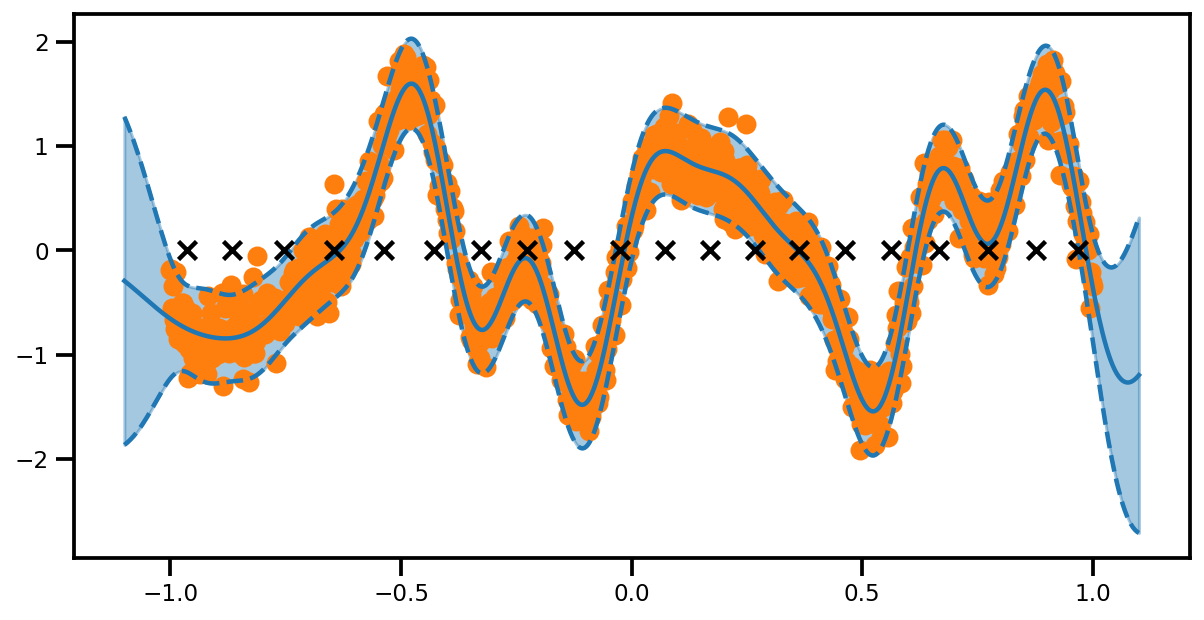

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu.ravel(), color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
plt.scatter(learned_params["x_u"], np.zeros(Ninducing), 
            label="Inducing Points", color="black", marker="x",
            zorder=3
            )
ax.plot(xtest, mu.ravel() - one_stddev_, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev_, linestyle="--", color="tab:blue")
plt.show()

### Uncertain Inputs

In [ ]:
input_var = jnp.array([0.001])
input_cov = input_var.reshape(-1, 1)

In [ ]:

xtest = jnp.linspace(-1.1, 1.1, 1_000).reshape(-1, 1)
ytest = f(xtest)

xtest_noise = xtest + input_var * jax.random.normal(key, shape=xtest.shape)
xtest_noise = np.sort(xtest_noise)
ytest_noise = f(xtest_noise)


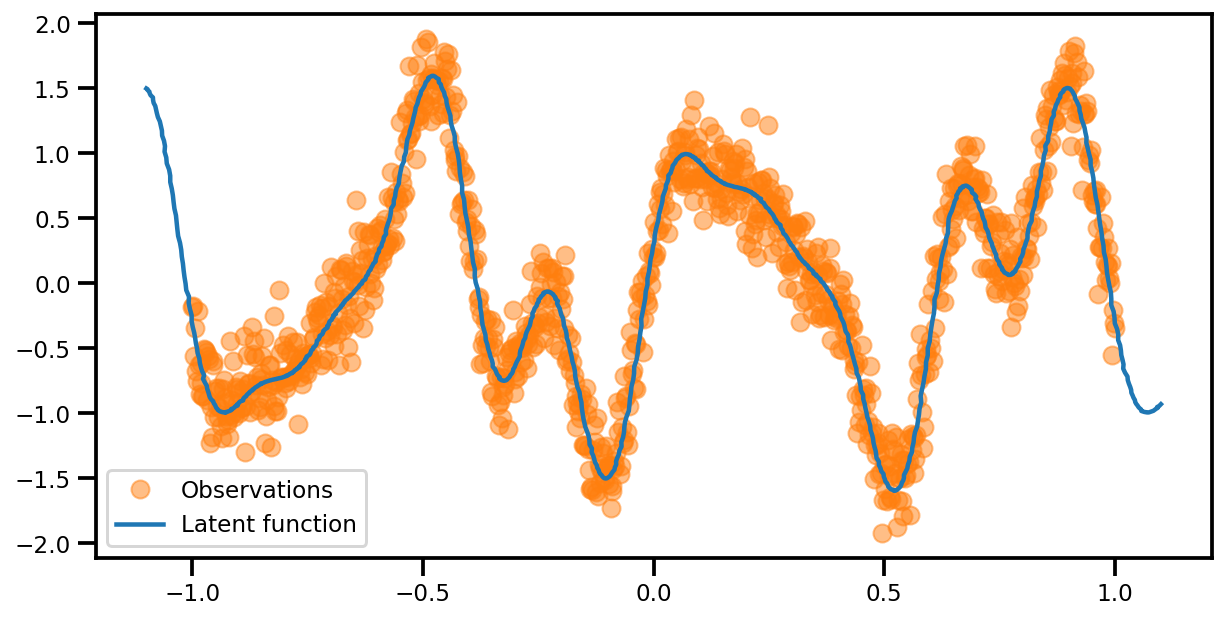

In [ ]:

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, "o", label="Observations", color="tab:orange", alpha=0.5)
ax.plot(xtest_noise, ytest, label="Latent function", color="tab:blue")
ax.legend(loc="best")
plt.show()

In [ ]:
mu = sparse_predict_mean(params, xtest)
var = sparse_predict_variance(params, xtest, noiseless=False)

# gradient predictive mean
sparse_predict_mean_grad = jax.vmap(jax.grad(sparse_predict_mean, argnums=1), in_axes=(None, 0))

# predictive mean
dmu = sparse_predict_mean_grad(params, xtest)

# predictive variance
var_to1 = jnp.diag(dmu @ input_cov @ dmu.T)
one_stddev_to1 = 1.96 * jnp.sqrt(var.squeeze() + var_to1.squeeze())
# cov = sparse_predict_covariance(params, xtest, noiseless=False)
# var = sparse_predict_variance(params, xtest, noiseless=False)

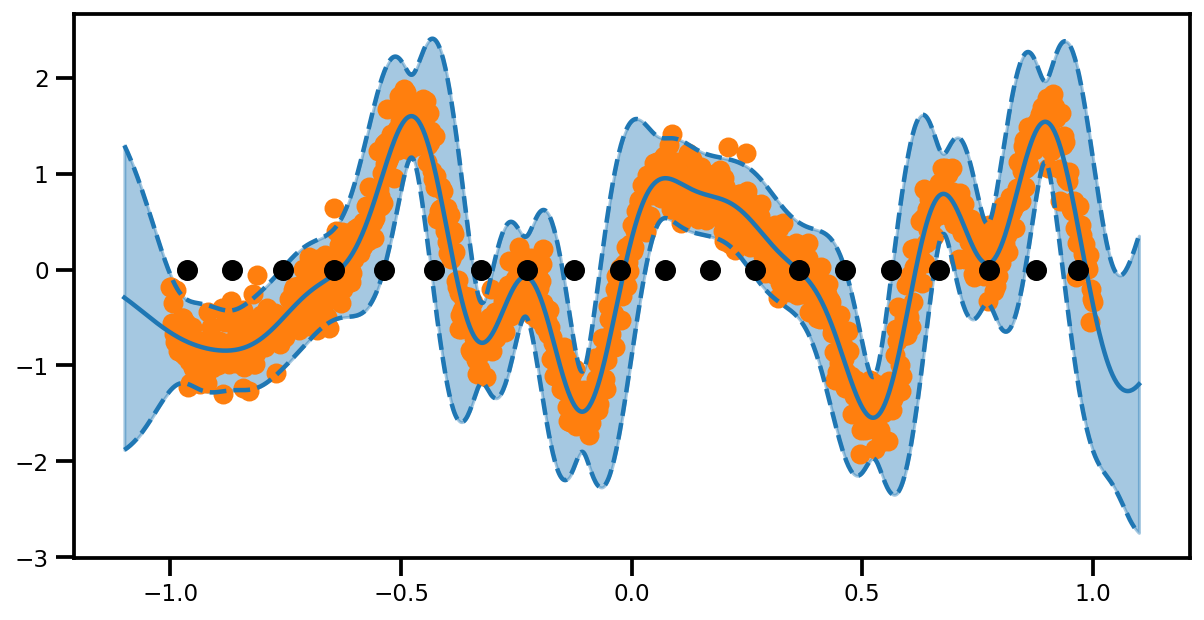

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu.ravel(), color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev_to1,
    mu.ravel() + one_stddev_to1,
    alpha=0.4,
    color="tab:blue",
)
plt.scatter(learned_params["x_u"], np.zeros(Ninducing), 
            label="Inducing Points", color="black", zorder=3
            )
ax.plot(xtest, mu.ravel() - one_stddev_to1, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev_to1, linestyle="--", color="tab:blue")
plt.show()